In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb
import numpy as np
import pickle,itertools
import shap
from sklearn.model_selection import train_test_split
plt.rcParams["figure.figsize"] = (10,7)

import pickle

import warnings
warnings.filterwarnings('ignore')


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
train_set = pd.read_csv('./data/train_df_expanded_KNN_imp_feats.csv')
train_set = train_set.replace([np.inf, -np.inf], np.nan)

y_train = train_set['Target']
x_train = train_set.drop(['Date', 'Target','Abs Target'], axis=1)
     
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.45, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.66, shuffle=False)
X_val_2, X_test, y_val_2, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)

X_val = X_val.iloc[5:]
y_val = y_val.iloc[5:]

X_train.columns=train_set.drop(['Date', 'Target','Abs Target'], axis=1).columns
X_val.columns=X_train.columns  

In [3]:
params = {'alpha': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'eta': 0.05, 'eval_metric': ['rmse'],
          'lambda': 1, 'max_depth': 4, 'objective': 'reg:squarederror', 'scale_pos_weight': 1, 'subsample': 0.7, 'tree_method': 'exact',
          'nthread': -2, 'base_score': 0}

dtrain = xgb.DMatrix(X_train[X_train['Target > 2']==0].drop(columns=['Target > 2']), y_train[X_train['Target > 2']==0])
dval = xgb.DMatrix(X_val[X_val['Target > 2']==0].drop(columns=['Target > 2']), y_val[X_val['Target > 2']==0])

reg = xgb.train(params,dtrain,evals=[(dtrain, 'train'),(dval, 'test')],num_boost_round=180,verbose_eval=True,early_stopping_rounds=10)

[0]	train-rmse:0.29570	test-rmse:0.22887
[1]	train-rmse:0.29297	test-rmse:0.22801
[2]	train-rmse:0.29028	test-rmse:0.22598
[3]	train-rmse:0.28793	test-rmse:0.22491
[4]	train-rmse:0.28566	test-rmse:0.22384
[5]	train-rmse:0.28363	test-rmse:0.22229
[6]	train-rmse:0.28164	test-rmse:0.22118
[7]	train-rmse:0.27972	test-rmse:0.21995
[8]	train-rmse:0.27797	test-rmse:0.21903
[9]	train-rmse:0.27629	test-rmse:0.21931
[10]	train-rmse:0.27467	test-rmse:0.21855
[11]	train-rmse:0.27270	test-rmse:0.21728
[12]	train-rmse:0.27130	test-rmse:0.21668
[13]	train-rmse:0.26992	test-rmse:0.21666
[14]	train-rmse:0.26863	test-rmse:0.21532
[15]	train-rmse:0.26741	test-rmse:0.21486
[16]	train-rmse:0.26629	test-rmse:0.21399
[17]	train-rmse:0.26479	test-rmse:0.21301
[18]	train-rmse:0.26369	test-rmse:0.21253
[19]	train-rmse:0.26268	test-rmse:0.21260
[20]	train-rmse:0.26162	test-rmse:0.21240
[21]	train-rmse:0.26074	test-rmse:0.21146
[22]	train-rmse:0.25951	test-rmse:0.21112
[23]	train-rmse:0.25860	test-rmse:0.21064
[2

In [5]:
y_pred_train = reg.predict(dtrain)
y_pred_val = reg.predict(dval)
feat_importance = reg.get_score(importance_type='gain')
feat_importance = {k: v for k, v in sorted(feat_importance.items(), key=lambda item: item[1], reverse=True)}
top_10_gain = list(feat_importance.keys())[:10]

feat_importance = reg.get_score(importance_type='weight')
feat_importance = {k: v for k, v in sorted(feat_importance.items(), key=lambda item: item[1], reverse=True)}
top_10_weight = list(feat_importance.keys())[:10]

explainer = shap.TreeExplainer(reg)
shap_values = explainer(X_train[X_train['Target > 2']==0].drop(columns=['Target > 2']))
shap_summary = pd.DataFrame(shap_values.values, columns=X_train[X_train['Target > 2']==0].drop(columns=['Target > 2']).columns)
mean_abs_shap_values = shap_summary.abs().mean().sort_values(ascending=False)
top_10_shap = mean_abs_shap_values.head(10).index.tolist()

top_K_feat = list(set(top_10_gain+top_10_weight+top_10_shap))

with open("./metadata/top_K_feat_low-values_reg.pkl", "wb") as f:
    pickle.dump(top_K_feat, f)

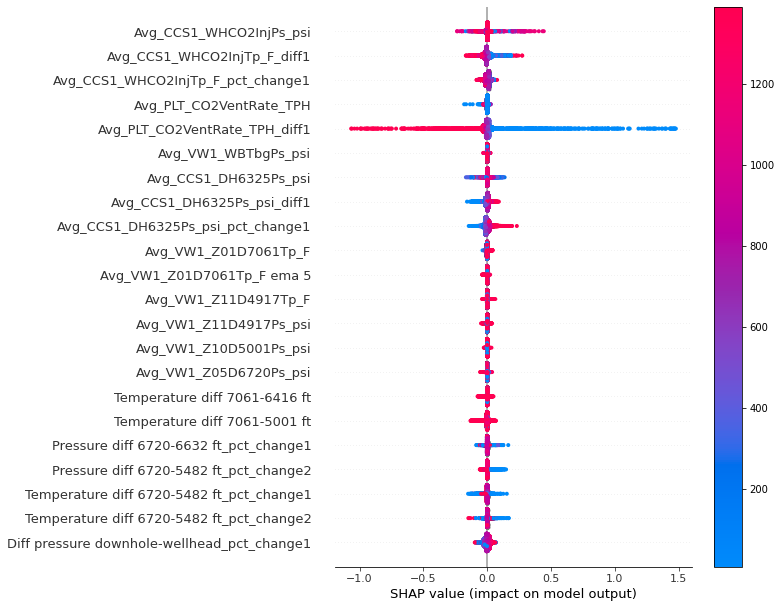

In [10]:
full_x=train_set.drop(columns=['Abs Target','Date', 'Target'])
full_y=train_set['Target']
full_y=full_y[full_x['Target > 2']==0]
full_x=full_x[full_x['Target > 2']==0]

cols=[
'Avg_CCS1_WHCO2InjPs_psi',
'Avg_CCS1_WHCO2InjTp_F_diff1',
'Avg_CCS1_WHCO2InjTp_F_pct_change1',

'Avg_PLT_CO2VentRate_TPH',
'Avg_PLT_CO2VentRate_TPH_diff1',

'Avg_VW1_WBTbgPs_psi',

'Avg_CCS1_DH6325Ps_psi',
'Avg_CCS1_DH6325Ps_psi_diff1',
'Avg_CCS1_DH6325Ps_psi_pct_change1',

'Avg_VW1_Z01D7061Tp_F',
'Avg_VW1_Z01D7061Tp_F ema 5',



'Avg_VW1_Z11D4917Tp_F',
'Avg_VW1_Z11D4917Ps_psi',

'Avg_VW1_Z10D5001Ps_psi',


'Avg_VW1_Z05D6720Ps_psi',
'Temperature diff 7061-6416 ft',
'Temperature diff 7061-5001 ft',
'Pressure diff 6720-6632 ft_pct_change1',
'Pressure diff 6720-5482 ft_pct_change2',
'Temperature diff 6720-5482 ft_pct_change1',
'Temperature diff 6720-5482 ft_pct_change2',

'Diff pressure downhole-wellhead_pct_change1',

]


full_x = full_x[cols]
dfull = xgb.DMatrix(full_x, full_y)

reg = xgb.train(params,dfull,num_boost_round=180)

# Calculate shap values
explainer = shap.TreeExplainer(reg)
shap_values = explainer(full_x)

order = full_x.columns
col2num = {col: i for i, col in enumerate(full_x)}
order = list(map(col2num.get, order))

shap.plots.beeswarm(shap_values, max_display=len(cols), show=False, color_bar=False, order=order)
plt.colorbar()
plt.show()


## Hyperparameter Tunning

In [27]:
y_train = train_set['Target']
x_train = train_set.drop(['Date', 'Target','Abs Target'], axis=1)

    
x_train = x_train[list(top_K_feat) + ['Target > 2']]

X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)

X_val = X_val.iloc[5:]
y_val = y_val.iloc[5:]

In [28]:
dtrain = xgb.DMatrix(X_train[X_train['Target > 2']==0].drop(columns=['Target > 2']), y_train[X_train['Target > 2']==0])
dval = xgb.DMatrix(X_val[X_val['Target > 2']==0].drop(columns=['Target > 2']), y_val[X_val['Target > 2']==0])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'alpha': [1, 5],
    'lambda': [1, 5],
    'colsample_bytree': [0.7, 1],
    'colsample_bylevel': [0.7, 1],
    'subsample': [0.7, 1],
    'tree_method': ['exact'],
    'nthread': [-2],
    'eta': [0.05],
    'max_depth': [4], 
    'objective': ['reg:squarederror'],
}

# Create a list of all combinations of hyperparameters
keys, values = zip(*param_grid.items())
hyperparameter_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

In [29]:
y_test2=y_val[X_val['Target > 2']==0]
y_test2.reset_index(drop=True,inplace=True)

# Initialize empty lists to store results
rmse_scores=[]
MAPE_scores=[]
hyparparams_list = []
num_trees_list = []

for hyperparams in hyperparameter_combinations:
    # Train your model with the current hyperparameters
    reg = xgb.train(hyperparams,dtrain,evals=[(dtrain, 'train'),(dval, 'test')],num_boost_round=1000,verbose_eval=False,early_stopping_rounds=5)

    # Make predictions on the test set
    y_pred_train = reg.predict(dtrain)
    y_pred_val = reg.predict(dval)

    num_trees = reg.best_ntree_limit
    num_trees_list.append(num_trees)

    rmse = np.sqrt(mean_squared_error(y_val[X_val['Target > 2']==0], y_pred_val))
    print('RMSE: {:.2f}'.format(rmse))
    rmse_scores.append(rmse)
    
    MAPE=mean_absolute_percentage_error(y_test2, y_pred_val, sample_weight=np.abs(y_test2)/sum(np.abs(y_test2)))
    print('MAPE: {:.2f}%'.format(MAPE))
    MAPE_scores.append(MAPE)

# Combine the results into a list of dictionaries
results = []
for i, hyperparams in enumerate(hyperparameter_combinations):
    results.append({
        'hyperparameters': hyperparams,
        'RMSE': rmse_scores[i],
        'MAPE': MAPE_scores[i],
    })

RMSE: 0.17
MAPE: 0.93%
RMSE: 0.17
MAPE: 0.91%
RMSE: 0.17
MAPE: 0.92%
RMSE: 0.17
MAPE: 0.90%
RMSE: 0.17
MAPE: 0.91%
RMSE: 0.17
MAPE: 0.91%
RMSE: 0.17
MAPE: 0.91%
RMSE: 0.17
MAPE: 0.91%
RMSE: 0.17
MAPE: 0.92%
RMSE: 0.17
MAPE: 0.91%
RMSE: 0.17
MAPE: 0.92%
RMSE: 0.17
MAPE: 0.91%
RMSE: 0.17
MAPE: 0.92%
RMSE: 0.17
MAPE: 0.89%
RMSE: 0.17
MAPE: 0.90%
RMSE: 0.17
MAPE: 0.91%
RMSE: 0.17
MAPE: 0.94%
RMSE: 0.17
MAPE: 0.91%
RMSE: 0.17
MAPE: 0.91%
RMSE: 0.17
MAPE: 0.91%
RMSE: 0.17
MAPE: 0.89%
RMSE: 0.17
MAPE: 0.90%
RMSE: 0.17
MAPE: 0.89%
RMSE: 0.17
MAPE: 0.91%
RMSE: 0.17
MAPE: 0.91%
RMSE: 0.17
MAPE: 0.92%
RMSE: 0.17
MAPE: 0.91%
RMSE: 0.17
MAPE: 0.90%
RMSE: 0.17
MAPE: 0.90%
RMSE: 0.17
MAPE: 0.91%
RMSE: 0.17
MAPE: 0.90%
RMSE: 0.17
MAPE: 0.91%


In [30]:
# Find the best hyperparameters based on the highest AUCPR
best_idx = np.argmin([x['RMSE'] for x in results])

# Get the best threshold, hyperparameters, and optimal number of trees
best_hyperparams = results[best_idx]['hyperparameters']
opt_num_trees = num_trees_list[best_idx]

print(results[best_idx])
print(f'Num of trees: {opt_num_trees}')

{'hyperparameters': {'alpha': 1, 'lambda': 5, 'colsample_bytree': 1, 'colsample_bylevel': 0.7, 'subsample': 1, 'tree_method': 'exact', 'nthread': -2, 'eta': 0.05, 'max_depth': 4, 'objective': 'reg:squarederror'}, 'RMSE': 0.16579121871669064, 'MAPE': 0.8946441560492594}
Num of trees: 227


## Testing results on validation set

In [31]:
y_train = train_set['Target']
x_train = train_set.drop(['Date', 'Target','Abs Target'], axis=1)
x_train = x_train[list(top_K_feat) +['Target > 2'] ]

X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.15, shuffle=False)


X_test = X_test.iloc[5:]
y_test = y_test.iloc[5:]

In [32]:
with open("./output/y_train3_clf_preds.pkl", "rb") as f:
    y_val_class = pickle.load(f)

In [33]:
X_test['Class']=y_val_class[-len(X_test):]

dtrain = xgb.DMatrix(X_train[X_train['Target > 2']==0].drop(columns=['Target > 2']), y_train[X_train['Target > 2']==0])
dval = xgb.DMatrix(X_test[X_test['Class']==0].drop(columns=['Class','Target > 2']), y_test[X_test['Class']==0])
reg= xgb.train(best_hyperparams,dtrain,num_boost_round=int(opt_num_trees*1.09))

preds_reg=reg.predict(dval)
rmse_class_0 = np.sqrt(mean_squared_error( y_test[X_test['Class']==0], preds_reg))
rmse_class_0

0.16275193481803338

In [ ]:
reg.save_model('./output/regressor_class0/negative_class_xgb_validation_regressor.json')

In [18]:
np.sqrt(mean_squared_error( y_test[X_test['Class']==0], [0 for i in range(len(y_test[X_test['Class']==0]))]))


0.22682364369967095

No handles with labels found to put in legend.


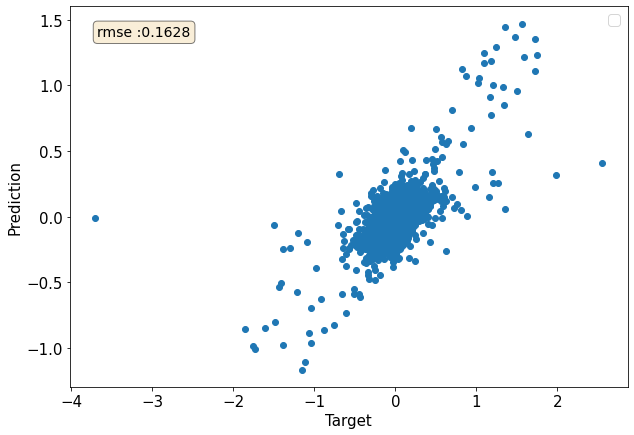

In [39]:
plt.scatter(y_test[X_test['Class']==0], preds_reg)
textstr = 'rmse :' + str(rmse_class_0.round(4))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
         verticalalignment='top', bbox=props)
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.rcParams.update({'font.size': 15})
plt.legend()
plt.show()

In [35]:
y_train = train_set['Target']
x_train = train_set.drop(['Date', 'Target','Abs Target'], axis=1)

x_train = x_train[list(top_K_feat) + ['Target > 2']]

dtrain = xgb.DMatrix(x_train[x_train['Target > 2']==0].drop(columns=['Target > 2']), y_train[x_train['Target > 2']==0])
reg= xgb.train(best_hyperparams,dtrain,num_boost_round=int(opt_num_trees*1.09))

reg.save_model('./output/regressor_class0/negative_class_xgb_final_regressor.json')